In [ ]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Apr 28 19:38:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   50C    P8              13W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 67.4 gigabytes of available RAM

You are using a high-RAM runtime!


#Рівняння Бюргерса. Точний розв'язок

$\displaystyle \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}$

**Тестова задача.**

Домен $x \in [0,1]$, $\nu=0.0015$

Граничні умови

$U(0,t)=U(1,t)=0$

$$

Початкові умови

$\displaystyle u(x,1) =  \frac{x}{1+\sqrt\frac{t}{t_0}\exp(x^2/4\nu )}, \ t\geq1$


[Ali Başhan. Nonlinear dynamics of the Burgers’ equation and numerical experiments Mathematical Sciences. 2021. https://doi.org/10.1007/s40096-021-00410-8
]:

**Точний розв'язок**

$\displaystyle u(x,t) =  \frac{x/t}{1+\sqrt\frac{t}{t_0}\exp(x^2/4\nu t)}, \ t\geq 1$

де $t_0=exp(1/8\nu)$

In [ ]:
import sympy as sp

# Оголошуємо символ x
x, t, t0, nu = sp.symbols('x t t0 nu')

t0 = sp.exp(1/(8*nu))

U = x/t/(1+sp.sqrt(t/t0)*sp.exp(x**2/(4*nu*t)))

print("u(x,t) = ", U)


u(x,t) =  x/(t*(sqrt(t*exp(-1/(8*nu)))*exp(x**2/(4*nu*t)) + 1))


In [ ]:
U

x/(t*(sqrt(t*exp(-1/(8*nu)))*exp(x**2/(4*nu*t)) + 1))

In [ ]:
nu_val = 0.0015

In [ ]:
U_subs = U.subs({nu:nu_val})

In [ ]:
f_U = sp.lambdify((x, t), U_subs, "numpy")

x_val = np.linspace(0, 1, num=1001)
t_val = np.linspace(1, 4, num=301)

X_val, T_val = np.meshgrid(x_val, t_val)

U_val = f_U(X_val, T_val)

U_val = U_val.T




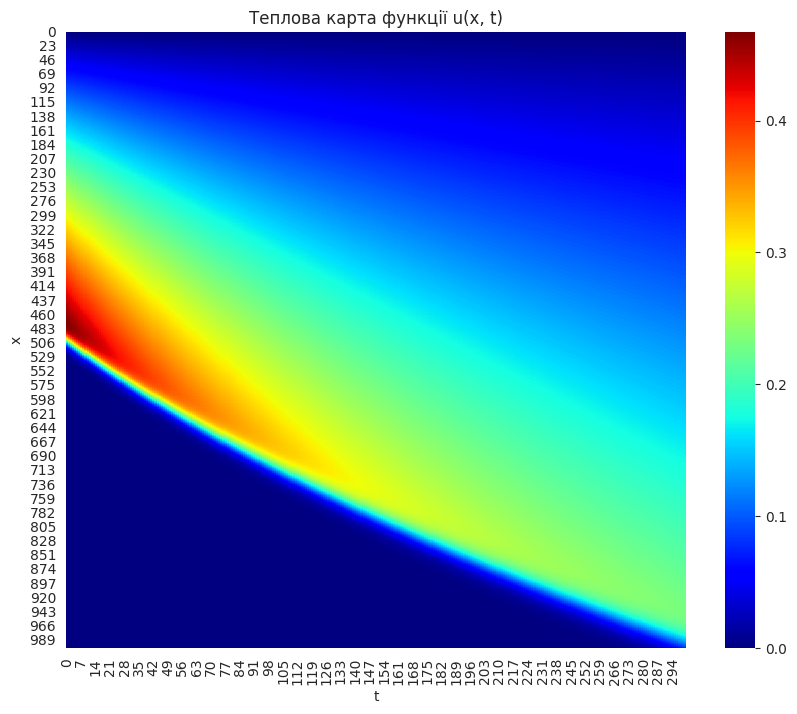

In [ ]:
sns.set_style("white")
plt.figure(figsize=(10,8))
sns.heatmap(U_val, cmap='jet')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Теплова карта функції u(x, t)')
plt.show()


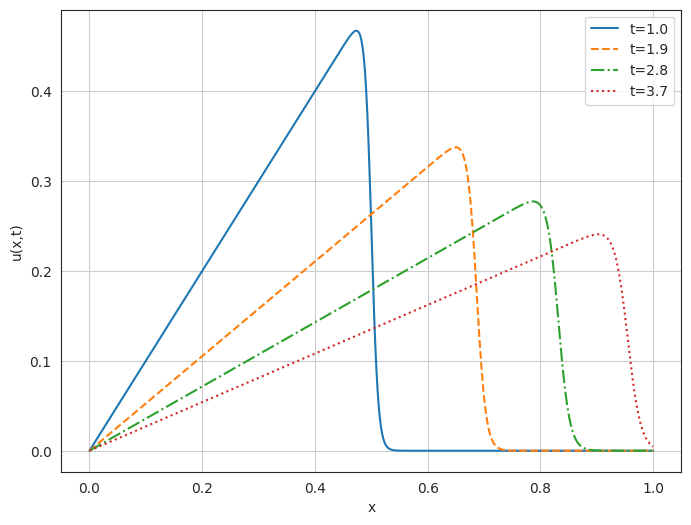

In [ ]:
# Побудова графіку
plt.figure(figsize=(8, 6))    # Розміри графіку (ширина, висота) в дюймах

plt.plot(x_val, U_val[:,0], label='t=1.0', linestyle='-')
plt.plot(x_val, U_val[:,90], label='t=1.9', linestyle='--')
plt.plot(x_val, U_val[:,180], label='t=2.8', linestyle='-.')
plt.plot(x_val, U_val[:,270], label='t=3.7', linestyle=':')

# Додавання заголовку, підписів вісей та легенди
# plt.title('Графік декількох кривих')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.legend()   # Виведення легенди з назвами кривих

# Показати графік
plt.grid(True)   # Включити сітку
plt.show()


#Розв'язок засобами PINN

In [ ]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(2,32),
            nn.Tanh(),
            nn.Linear(32,32),
            # nn.Tanh(),
            # nn.Linear(20,20),

            nn.Tanh(),
            nn.Linear(32,1)
        )

    def forward(self, x):
        out = self.net(x)
        return out

In [ ]:
'''
x_test = torch.arange(-1,1+0.1, 0.1)
#print(x_test)
t_test = torch.arange(0,1+0.1, 0.1)
#print(t_test)

X = torch.stack(torch.meshgrid(x_test,t_test)).reshape(2,-1).T
#print(X)

bc1_test = torch.stack(torch.meshgrid(x_test[-1],t_test)).reshape(2,-1).T
#print(bc1_test)
#print(torch.meshgrid(x_test,t_test))

y_train_test = torch.tensor([1,2,3,4])
print(y_train_test)
y_train_test = y_train_test.unsqueeze(1)
print(y_train_test)
'''

'\nx_test = torch.arange(-1,1+0.1, 0.1)\n#print(x_test)\nt_test = torch.arange(0,1+0.1, 0.1)\n#print(t_test)\n\nX = torch.stack(torch.meshgrid(x_test,t_test)).reshape(2,-1).T\n#print(X)\n\nbc1_test = torch.stack(torch.meshgrid(x_test[-1],t_test)).reshape(2,-1).T\n#print(bc1_test)\n#print(torch.meshgrid(x_test,t_test))\n\ny_train_test = torch.tensor([1,2,3,4])\nprint(y_train_test)\ny_train_test = y_train_test.unsqueeze(1)\nprint(y_train_test)\n'

In [ ]:
# h = 0.01
# k = 0.01
# nu = 0.5

# x = torch.arange(0,8+h, h)
# t = torch.arange(0,5+k, k)

# X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
# bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T

# # bc2[:,1]+10e-5
# # X[:,1]
# # bc2.size()
# # X.size()
# y_bc2 = (bc2[:,0]/(bc2[:,1]+10e-6))*1/(1+torch.sqrt((bc2[:,1]+10e-6)*nu/0.125)*torch.exp(bc2[:,0]**2/4*nu*(bc2[:,1]+10e-6)))
# y_bc2

torch.pi

3.141592653589793

In [ ]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN().to(device)

        self.x_max = 1
        self.t_max = 4

        # comp. domain
        self.h = 0.001
        self.k = 0.01
        self.nu = 0.0015
        self.epoch = 2000

        x = torch.arange(0, self.x_max + self.h, self.h)
        t = torch.arange(1, self.t_max + self.k, self.k)


        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
        # print('self.X ', self.X.shape)
        # breakpoint()



        # train data
        bc1 = torch.stack(torch.meshgrid(x[0],t)).reshape(2,-1).T
        bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T
        ic  = torch.stack(torch.meshgrid(x,t[0])).reshape(2,-1).T
        # ic2  = torch.stack(torch.meshgrid(x,t[-1])).reshape(2,-1).T
        # print('bc1, ', bc1.shape)
        # print('bc2, ', bc2.shape)
        # print('ic, ', ic.shape)
        # breakpoint()

        self.X_train = torch.cat([bc1, bc2, ic])

        # print('self.X_train ', self.X_train.shape)
        # breakpoint()

        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))

        t0 = torch.exp(torch.tensor([1/(8*self.nu)]))

        y_ic  = ic[:,0] / (1 + torch.sqrt(1/t0)*torch.exp((ic[:,0]**2)/(4*self.nu)))

        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])


        self.y_train = self.y_train.unsqueeze(1)



        self.X = self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        self.X.requires_grad = True

        # optimizer setting
        self.adam =  torch.optim.Adam(self.model.parameters())
        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 2000,
            max_eval = 2000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )

        self.criterion = torch.nn.MSELoss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        y_pred = self.model(self.X_train)

        # print('y_pred ', y_pred.shape)
        # print('self.y_train.shape ', self.y_train.shape)
        # breakpoint()


        loss_data = self.criterion(y_pred - self.y_train, torch.zeros_like(self.y_train))

        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]

        #print(du_dX)
        #print("xxxxxxxxxxxxxxxxxxxxxxxxx")
        #print(du_dX[0])

        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]

        # print('du_dx ', du_dx.shape)
        # print('du_dt ', du_dt.shape)
        # breakpoint()


        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs = torch.ones_like(du_dX),
            create_graph = True,
            retain_graph = True
        )[0]

        du_dxx = du_dXX[:,0]

        loss_pde = self.criterion(du_dt + u.squeeze()*du_dx - self.nu * du_dxx, torch.zeros_like(du_dxx))

        loss = loss_pde + loss_data
        loss.backward()

        if self.iter % 100 == 0:
            print(self.iter, loss.item())
            print(loss_pde.item())
            print(loss_data.item())
        self.iter = self.iter+1

        return loss

    def train(self):
        self.model.train()
        for i in range(self.epoch):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

In [ ]:
# training
net = Net()
net.train()

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


100 0.015896622091531754
0.0007530379807576537
0.01514358352869749
200 0.015206429176032543
0.0008432603208348155
0.014363168738782406
300 0.014404218643903732
0.0008825777913443744
0.013521640561521053
400 0.012702753767371178
0.0007241953280754387
0.011978558264672756
500 0.008957184851169586
0.0005005193524993956
0.008456665091216564
600 0.006111763417720795
0.000955800584051758
0.0051559628918766975
700 0.004610095173120499
0.0011237090220674872
0.0034863862674683332
800 0.003991829231381416
0.0012454725801944733
0.0027463568840175867
900 0.0037090289406478405
0.0012929824879392982
0.002416046569123864
1000 0.003542691469192505
0.0013033890863880515
0.002239302499219775
1100 0.003424673806875944
0.0012994838180020452
0.002125190105289221
1200 0.0033283180091530085
0.001291831722483039
0.0020364862866699696
1300 0.0032440079376101494
0.0012849187478423119
0.0019590891897678375
1400 0.0031651132740080357
0.001277542905882001
0.0018875703681260347
1500 0.0030839694663882256
0.00126692

In [ ]:
net.model.eval()

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [ ]:
h = 0.001
k = 0.01

x = torch.arange(0, net.x_max+h,h)
t = torch.arange(1, net.t_max+k,k)

X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X = X.to(net.X.device)

In [ ]:
X

tensor([[0.0000, 1.0000],
        [0.0000, 1.0100],
        [0.0000, 1.0200],
        ...,
        [1.0000, 3.9800],
        [1.0000, 3.9900],
        [1.0000, 4.0000]], device='cuda:0')

In [ ]:
X.shape

torch.Size([301301, 2])

In [ ]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X)
    y_pred = y_pred.reshape(len(x),len(t)).cpu().numpy()

In [ ]:
y_pred.shape

(1001, 301)

In [ ]:
y_pred

array([[-3.2763183e-04, -3.4080446e-04, -3.4998357e-04, ...,
        -1.4607608e-04, -1.5155971e-04, -1.5704334e-04],
       [ 6.7777932e-04,  6.5387785e-04,  6.3402951e-04, ...,
         8.2984567e-05,  7.6904893e-05,  7.0586801e-05],
       [ 1.6831309e-03,  1.6484410e-03,  1.6179830e-03, ...,
         3.1210482e-04,  3.0519068e-04,  2.9845536e-04],
       ...,
       [-7.8293681e-04, -7.6553226e-04, -7.4350834e-04, ...,
         2.7456775e-02,  3.0746594e-02,  3.4312442e-02],
       [-7.9859793e-04, -7.8110397e-04, -7.5866282e-04, ...,
         2.4941638e-02,  2.8004363e-02,  3.1335726e-02],
       [-8.1443787e-04, -7.9667568e-04, -7.7404082e-04, ...,
         2.2610590e-02,  2.5454447e-02,  2.8557017e-02]], dtype=float32)

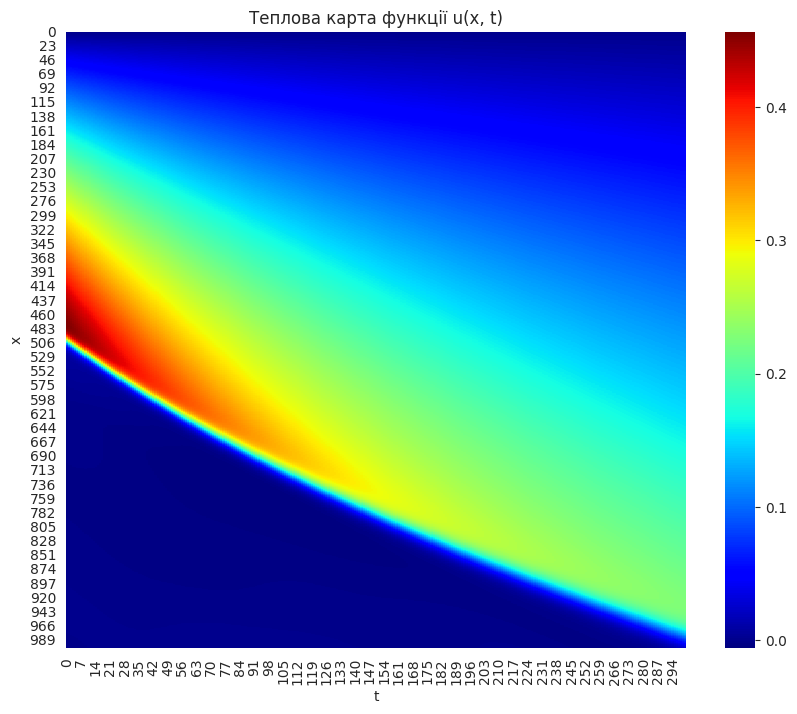

In [ ]:
sns.set_style("white")
plt.figure(figsize=(10,8))
sns.heatmap(y_pred, cmap='jet')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Теплова карта функції u(x, t)')
plt.show()



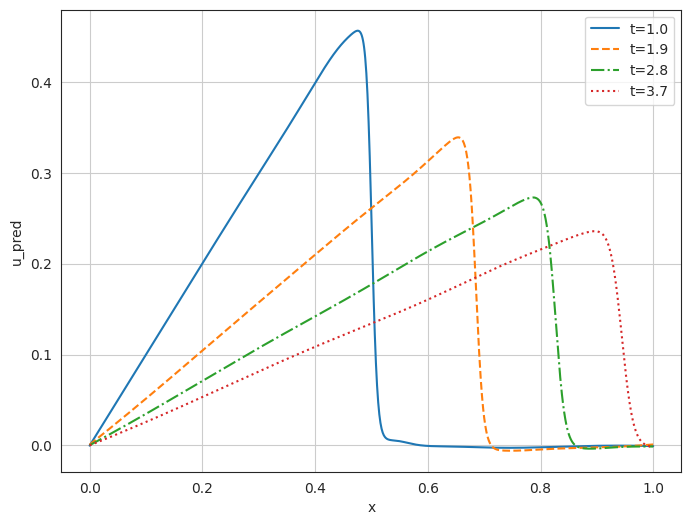

In [ ]:
# Побудова графіку
plt.figure(figsize=(8, 6))    # Розміри графіку (ширина, висота) в дюймах

plt.plot(x, y_pred[:,0], label='t=1.0', linestyle='-')
plt.plot(x, y_pred[:,90], label='t=1.9', linestyle='--')
plt.plot(x, y_pred[:,180], label='t=2.8', linestyle='-.')
plt.plot(x, y_pred[:,270], label='t=3.7', linestyle=':')

# Додавання заголовку, підписів вісей та легенди
# plt.title('Графік декількох кривих')
plt.xlabel('x')
plt.ylabel('u_pred')
plt.legend()   # Виведення легенди з назвами кривих

# Показати графік
plt.grid(True)   # Включити сітку
plt.show()




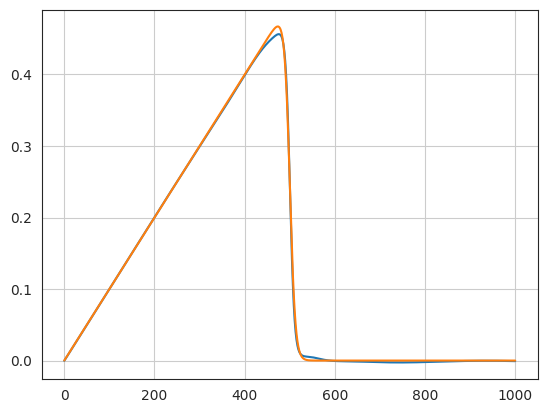

In [ ]:
plt.plot(y_pred[:,0])
plt.plot(U_val[:,0])

plt.grid(True)
plt.show()

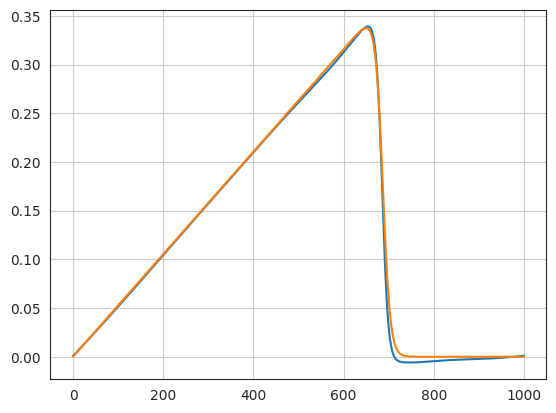

In [ ]:
plt.plot(y_pred[:,90])
plt.plot(U_val[:,90])

plt.grid(True)
plt.show()

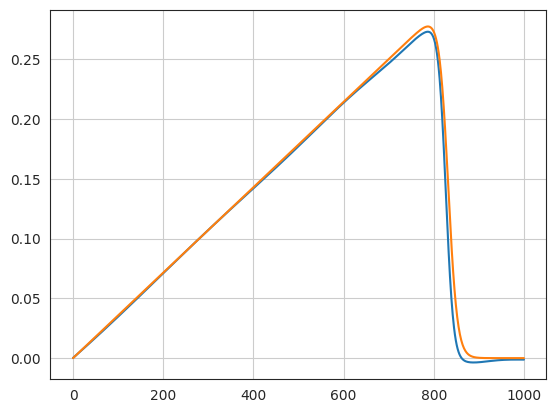

In [ ]:
plt.plot(y_pred[:,180])
plt.plot(U_val[:,180])

plt.grid(True)
plt.show()

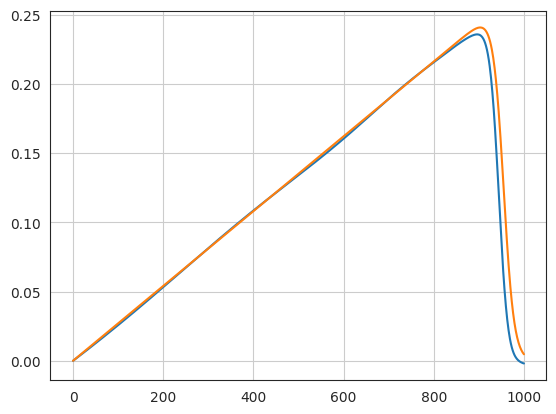

In [ ]:
plt.plot(y_pred[:,270])
plt.plot(U_val[:,270])

plt.grid(True)
plt.show()

In [ ]:
U_val.shape

(1001, 301)

In [ ]:
y_pred.shape

(1001, 301)

In [ ]:
from sklearn.metrics import r2_score

r2_score(U_val, y_pred)

0.9908680908758294

#Обернена задача

In [ ]:
class Net_inv:
    def __init__(self, uf):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.viscosity_coeff = 0.0015
        lambda_value = 1.0


        print("the real value =",self.viscosity_coeff, "     Our I-PINNs value=", lambda_value)
        self.lambda_value = torch.tensor([lambda_value], requires_grad=True).float().to(device)

        self.lambda_value = nn.Parameter(self.lambda_value)

        self.model = NN().to(device)

        self.model.register_parameter('lambda_value', self.lambda_value)

        self.x_max = 1
        self.t_max = 4
        # comp. domain
        self.h = 0.001
        self.k = 0.01

        self.epoch = 5000

        self.lambda_hist = []
        x = torch.arange(0, self.x_max + self.h, self.h)
        t = torch.arange(1, self.t_max + self.k, self.k)




        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
        # print('self.X ', self.X.shape)
        # breakpoint()

        print(self.X)

        # train data

        self.X_train = self.X

        self.y_train = torch.tensor(uf)

        self.y_train = self.y_train.view(-1)
        self.y_train = self.y_train.unsqueeze(1)

        print(self.y_train)

        # breakpoint()

        self.X = self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        self.X.requires_grad = True

        # optimizer setting
        self.adam =  torch.optim.Adam(self.model.parameters())
        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 6000,
            max_eval = 6000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )

        self.criterion = torch.nn.MSELoss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        y_pred = self.model(self.X_train)

        # print('y_pred ', y_pred.shape)
        # print('self.y_train.shape ', self.y_train.shape)
        # breakpoint()


        loss_data = self.criterion(y_pred - self.y_train, torch.zeros_like(self.y_train))

        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]

        #print(du_dX)
        #print("xxxxxxxxxxxxxxxxxxxxxxxxx")
        #print(du_dX[0])

        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]

        # print('du_dx ', du_dx.shape)
        # print('du_dt ', du_dt.shape)
        # breakpoint()


        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs = torch.ones_like(du_dX),
            create_graph = True,
            retain_graph = True
        )[0]

        du_dxx = du_dXX[:,0]

        lambda_pde  = self.lambda_value

        loss_pde = self.criterion(du_dt + u.squeeze()*du_dx - lambda_pde * du_dxx, torch.zeros_like(du_dxx))

        loss = loss_pde + loss_data
        loss.backward()

        self.lambda_hist.append(self.lambda_value.item())
        if self.iter % 100 == 0:
            print("iteration number =",self.iter, " loss value =", loss.item(), "real mu=",self.viscosity_coeff,"IPINN lambda=", self.lambda_value.item())
        self.iter = self.iter+1

        return loss

    def train(self):
        self.model.train()
        for i in range(self.epoch):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

In [ ]:
net_inv = Net_inv(y_pred)
net_inv.train()
net_inv.model.eval()

the real value = 0.0015      Our I-PINNs value= 1.0
tensor([[0.0000, 1.0000],
        [0.0000, 1.0100],
        [0.0000, 1.0200],
        ...,
        [1.0000, 3.9800],
        [1.0000, 3.9900],
        [1.0000, 4.0000]])
tensor([[-0.0003],
        [-0.0003],
        [-0.0003],
        ...,
        [ 0.0226],
        [ 0.0255],
        [ 0.0286]])
iteration number = 100  loss value = 0.010615726001560688 real mu= 0.0015 IPINN lambda= 0.9586301445960999
iteration number = 200  loss value = 0.010234907269477844 real mu= 0.0015 IPINN lambda= 0.9237982034683228
iteration number = 300  loss value = 0.009572740644216537 real mu= 0.0015 IPINN lambda= 0.9248148202896118
iteration number = 400  loss value = 0.00914110615849495 real mu= 0.0015 IPINN lambda= 0.9340308308601379
iteration number = 500  loss value = 0.008932643570005894 real mu= 0.0015 IPINN lambda= 0.9122628569602966
iteration number = 600  loss value = 0.008818132802844048 real mu= 0.0015 IPINN lambda= 0.8709350824356079
iteration

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [ ]:
h = 0.001
k = 0.01

x = torch.arange(0, net.x_max+h,h)
t = torch.arange(1, net.t_max+k,k)

X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X = X.to(net.X.device)

model = net_inv.model
model.eval()
with torch.no_grad():
    y_pred_inv = model(X)
    y_pred_inv = y_pred_inv.reshape(len(x),len(t)).cpu().numpy()

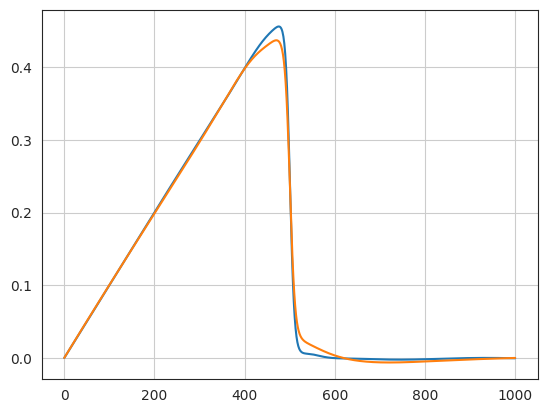

In [ ]:
plt.plot(y_pred[:,0])
plt.plot(y_pred_inv[:,0])

plt.grid(True)
plt.show()

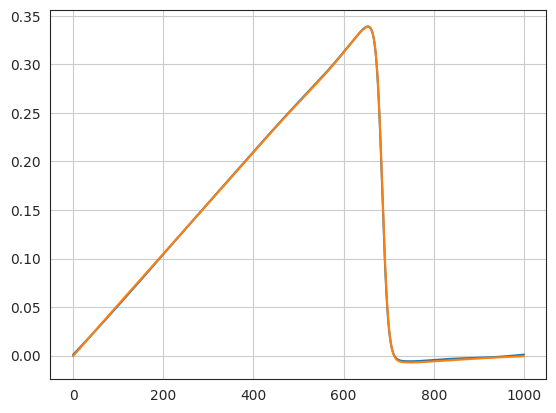

In [ ]:
plt.plot(y_pred[:,90])
plt.plot(y_pred_inv[:,90])

plt.grid(True)
plt.show()

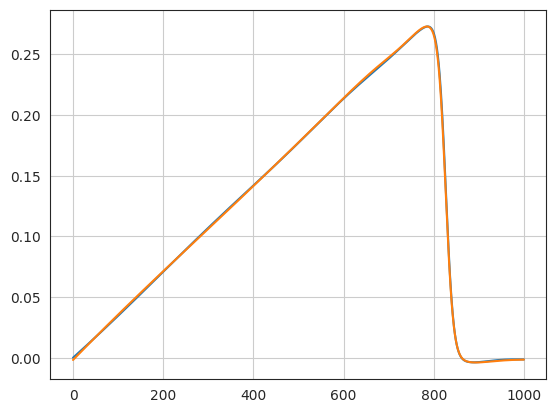

In [ ]:
plt.plot(y_pred[:,180])
plt.plot(y_pred_inv[:,180])

plt.grid(True)
plt.show()

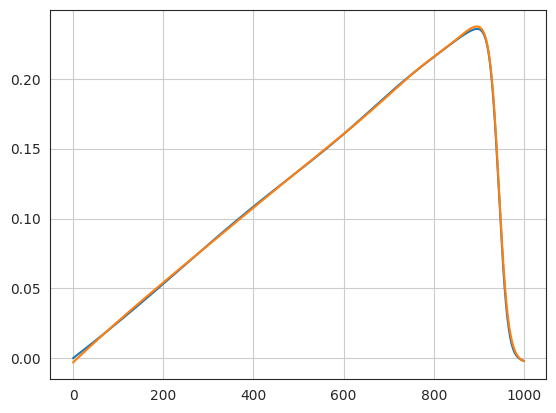

In [ ]:
plt.plot(y_pred[:,270])
plt.plot(y_pred_inv[:,270])

plt.grid(True)
plt.show()

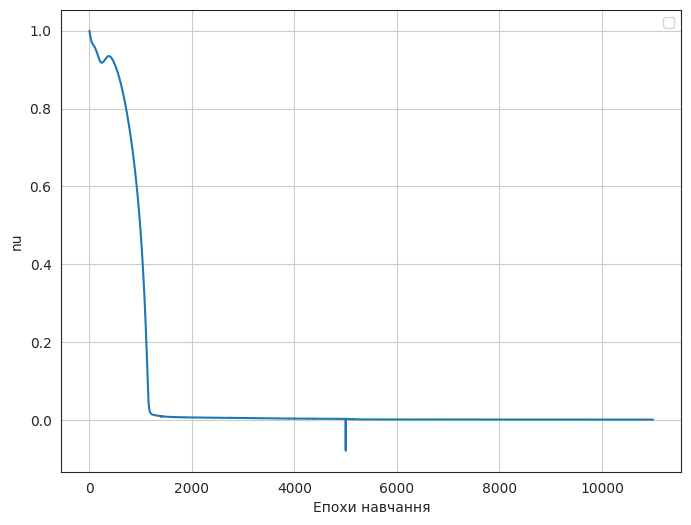

In [ ]:
# Побудова графіку
plt.figure(figsize=(8, 6))    # Розміри графіку (ширина, висота) в дюймах

plt.plot(net_inv.lambda_hist)

# Додавання заголовку, підписів вісей та легенди
# plt.title('Графік декількох кривих')
plt.xlabel('Eпохи навчання')
plt.ylabel('nu')
plt.legend()   # Виведення легенди з назвами кривих

# Показати графік
plt.grid(True)   # Включити сітку
plt.show()


In [ ]:
net.nu

0.0015

In [ ]:
net_inv.lambda_hist[-1]

0.0015326658030971885

In [ ]:
np.abs(net.nu - net_inv.lambda_hist[-1])/net.nu*100

2.1777202064792296